In [23]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl

In [24]:
""" This is code for simple GP regression. It assumes a zero mean GP Prior """

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()

# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = .5
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

In [25]:
N = 10         # number of training points.
n = 50         # number of test points.
s = 0.00005    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

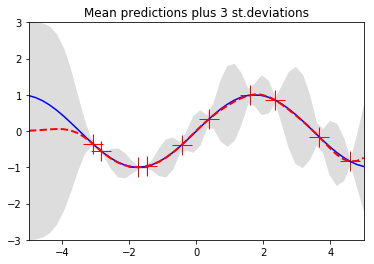

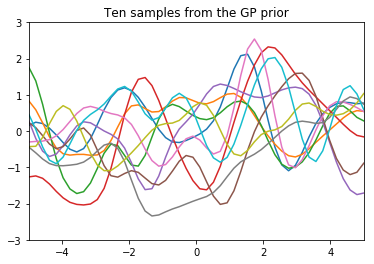

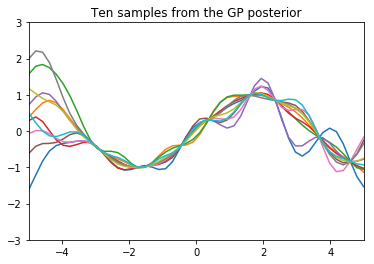

In [26]:
# PLOTS:
pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=20) #truth values that we are given
pl.plot(Xtest, f(Xtest), 'b-')#what the test values should be
pl.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2) #mean values of prediction
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [27]:
import pandas as pd

In [28]:
all_genes = pd.read_csv('Data/PPG_AT2_RNAseq_covariance_input_filt_0419.tsv',sep='\t',usecols=[0,2,3])

In [29]:
all_genes.head()

,MGI.symbol,AvgChrs,AT2_04M_F0
0,Gnai3,2.675624,7.151432
1,Cdc45,15.191392,1.347537
2,Narf,10.993152,4.248040
3,Cav2,5.115437,6.162987
4,Klf6,12.048712,6.635019


In [30]:
len(all_genes['MGI.symbol'])

14034

In [31]:
len(set(all_genes['MGI.symbol']))

14034

In [32]:
#Data frame containing missing genes
missing_genes = all_genes[all_genes['AT2_04M_F0']==0]
#Data frame containing genes we have
gene_exp = all_genes[all_genes['AT2_04M_F0']!=0]

In [33]:
#Subset data into different partitions to test how much data the GP needs
data_percent = 0.5

msk = np.random.rand(len(gene_exp)) < data_percent
train = gene_exp[msk]
test = gene_exp[~msk]

In [34]:
train.head()

,MGI.symbol,AvgChrs,AT2_04M_F0
0,Gnai3,2.675624,7.151432
3,Cav2,5.115437,6.162987
5,Scmh1,3.769722,5.245503
6,Cox5a,8.461710,5.426985
12,Brat1,4.926746,3.802135


In [35]:
chrm1 = train[train['AvgChrs']<=1]
chrm1_test = test[test['AvgChrs']<=1]

In [36]:
len(chrm1)+len(chrm1_test)

817

In [37]:
print(len(chrm1))
print(len(chrm1_test))

436
381


Text(0, 0.5, 'Gene Expression log2?')

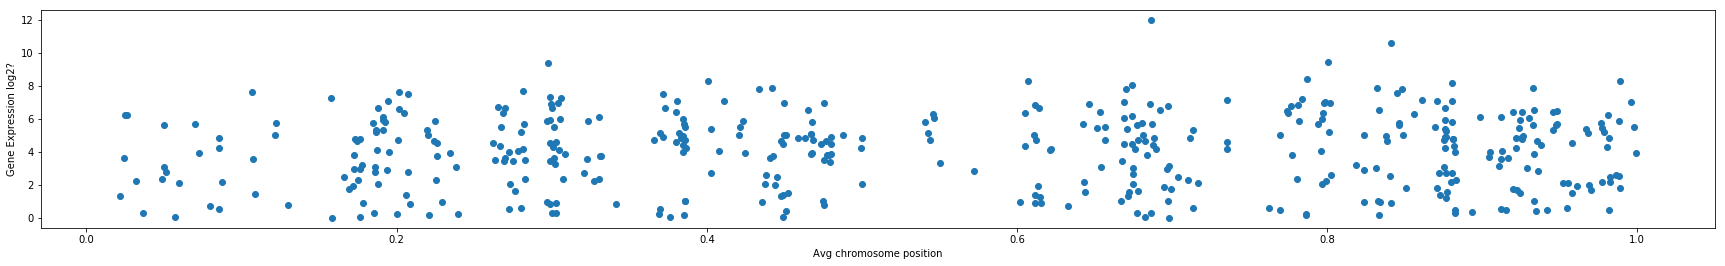

In [38]:
fig1 = pl.figure()
fig1.set_size_inches((30,4))
ax = fig1.add_subplot(111)
ax.scatter(chrm1['AvgChrs'],chrm1['AT2_04M_F0'])
ax.set_xlabel("Avg chromosome position")
ax.set_ylabel("Gene Expression log2?")


Text(0, 0.5, 'Gene Expression log2?')

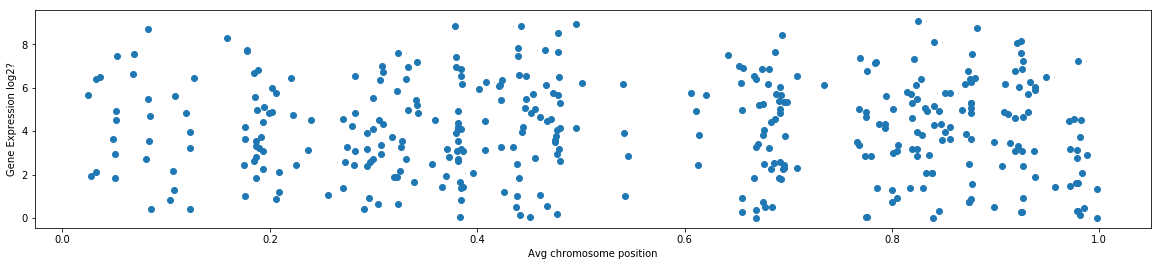

In [39]:
fig1 = pl.figure()
fig1.set_size_inches((20,4))
ax = fig1.add_subplot(111)
ax.scatter(chrm1_test['AvgChrs'],chrm1_test['AT2_04M_F0'])
ax.set_xlabel("Avg chromosome position")
ax.set_ylabel("Gene Expression log2?")

In [40]:
#X is (x,1) dimension
#K = kernel(X, X)
s = 0.00005    # noise variance.
pos = np.array(chrm1['AvgChrs']).reshape(-1,1)
y = np.array(chrm1['AT2_04M_F0'])
cov = kernel(pos,pos)
L = np.linalg.cholesky(cov + s*np.eye(len(pos)))

#points where we will make predictions at
pos_test = np.array(chrm1_test['AvgChrs']).reshape(-1,1)

#True test point values
y_test = np.array(chrm1_test['AT2_04M_F0'])

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(pos, pos_test))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(pos_test, pos_test)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

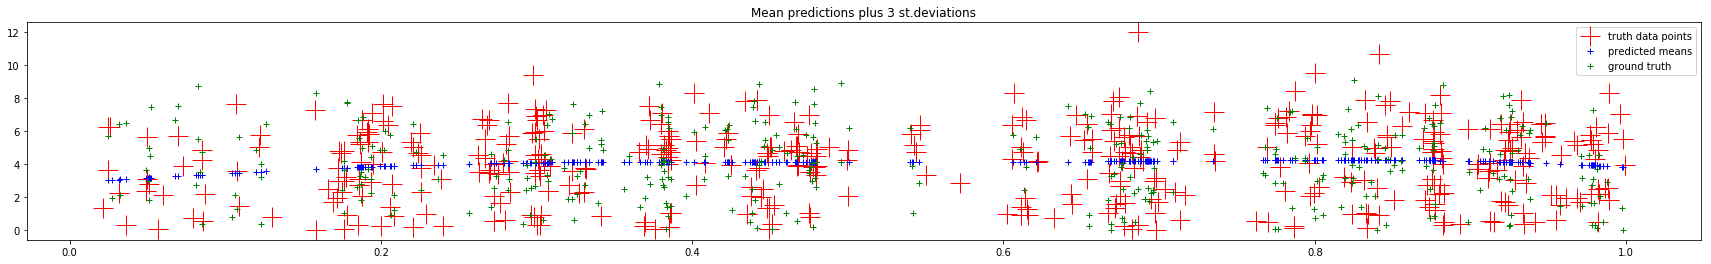

In [55]:
# PLOTS:
fig1 = pl.figure()
fig1.set_size_inches((30,4))
ax = fig1.add_subplot(111)
ax.plot(pos, y, 'r+', ms=20, label='truth data points') #truth values that we are given
#pl.gca().fill_between(pos_test.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(pos_test, mu, 'b+', lw=1, label='predicted means') #mean values of prediction
pl.plot(pos_test, y_test, 'g+',label='ground truth')#what the test values should be
pl.title('Mean predictions plus 3 st.deviations')
ax.plot()
ax.legend()

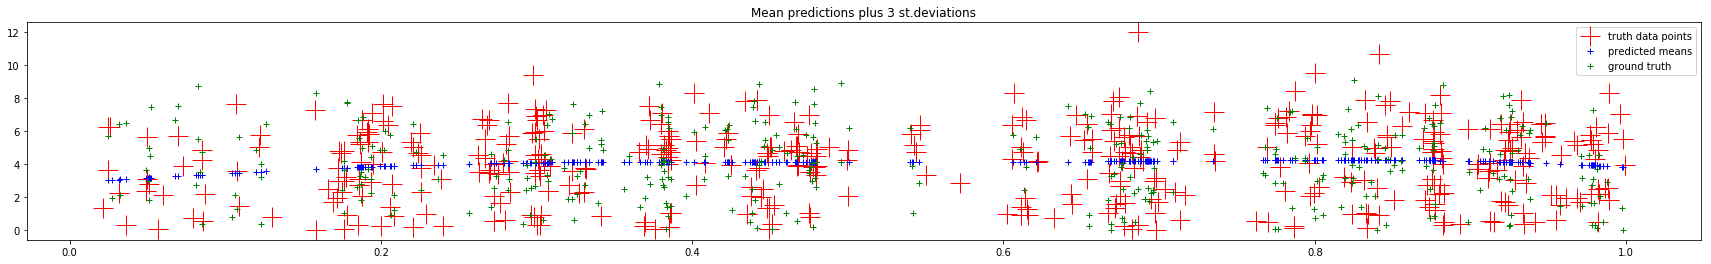

In [56]:
# PLOTS:
fig1 = pl.figure()
fig1.set_size_inches((30,4))
ax = fig1.add_subplot(111)
ax.plot(pos, y, 'r+', ms=20, label='truth data points') #truth values that we are given
#pl.gca().fill_between(pos_test.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(pos_test, mu, 'b+', lw=1, label='predicted means') #mean values of prediction
pl.plot(pos_test, y_test, 'g+',label='ground truth')#what the test values should be
pl.title('Mean predictions plus 3 st.deviations')
ax.plot()
ax.legend()

In [63]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = RBF(0.01)
gp = GaussianProcessRegressor(kernel=kernel,  normalize_y=True,n_restarts_optimizer=9) #means 1 run for optimizer or something
gp.fit(pos,y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=0.01), n_restarts_optimizer=9,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [64]:
y_pred, sigma = gp.predict(pos_test, return_std=True)

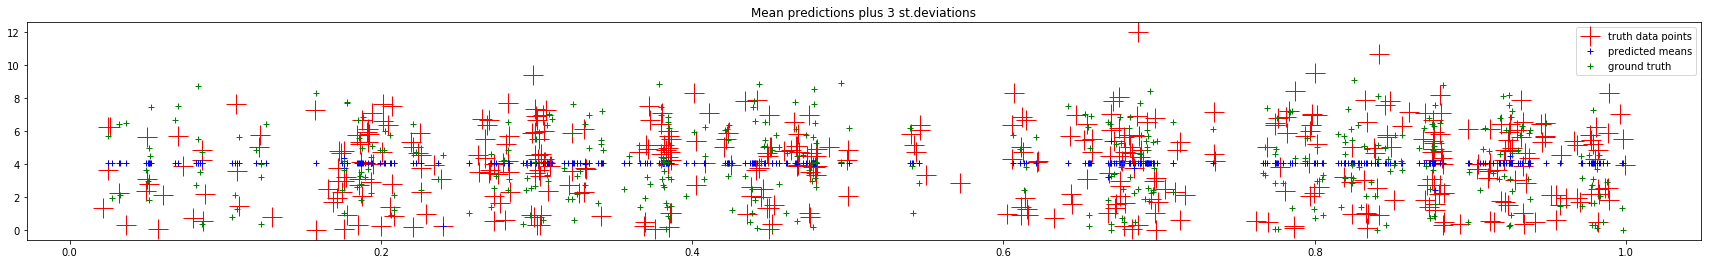

In [65]:
# PLOTS:
fig1 = pl.figure()
fig1.set_size_inches((30,4))
ax = fig1.add_subplot(111)
ax.plot(pos, y, 'r+', ms=20, label='truth data points') #truth values that we are given
#pl.gca().fill_between(pos_test.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(pos_test, y_pred, 'b+', lw=1, label='predicted means') #mean values of prediction
pl.plot(pos_test, y_test, 'g+',label='ground truth')#what the test values should be
pl.title('Mean predictions plus 3 st.deviations')
ax.plot()
ax.legend()

In [46]:
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

#class sklearn.gaussian_process.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0))
# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()b
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

SyntaxError: invalid syntax (<ipython-input-46-6673dc913017>, line 35)